# Simulate proteome time profiles. Perturbation midway by removing carbon source, forcing starvation

In [1]:
PROTOTYPE = True

In [2]:
from dynamicme.tests.helpme import HelpME
from dynamicme.dynamic import get_cplx_concs

helper = HelpME(prototyping=PROTOTYPE)
solver = helper.solver
me = solver.me

In [3]:
cplx_concs_max = get_cplx_concs(solver)

## Make sure delayme works

In [4]:
mu_me = me.solution.x_dict['biomass_dilution']
print 'mu of ME:', mu_me

mu of ME: 0.845886230469


In [5]:
from dynamicme.dynamic import DelayedDynamicME

dyme = DelayedDynamicME(solver)
dyme.delay_model.solver.set_realopts('lp', {'Feasibility tol':1e-15,'Optimality tol':1e-15})
dsolver = dyme.delay_model.solver

In [6]:
%%time
### Make sure it solves
dyme.delay_model.update_cplx_concs(cplx_concs_max)
dyme.delay_model.update_horizon(0.01)
x,stat,hs = dsolver.solvelp(mu_me)
dme = dyme.delay_model.mod_me
print 'DelayME:', stat, 'at', dme.reactions.biomass_dilution.x
x_dict_max = dict(dsolver.me.solution.x_dict)

DelayME: optimal at 0.845886230469
CPU times: user 4.47 s, sys: 60 ms, total: 4.53 s
Wall time: 4.49 s


# Test 2: Should be able to grow at any slower rate starting from initial proteome for faster growth
- can just scale down formation rates
- as long as rxns allowed to be slower than keff*E, which we did do here

In [7]:
%%time

dyme.delay_model.update_cplx_concs(cplx_concs_max)
dyme.delay_model.update_horizon(0.01)
x,stat,hs = dsolver.solvelp(mu_me*0.5)
print stat
x_dict_opt2 = dict(dsolver.me.solution.x_dict)
cplx_concs_opt2 = get_cplx_concs(dsolver)

optimal
CPU times: user 2.13 s, sys: 33.3 ms, total: 2.16 s
Wall time: 2.09 s


### Difference in cplx concs? Or no change and just under utilizing enzyme capacity?

In [8]:
for k in cplx_concs_max.keys():
    c1 = cplx_concs_max[k]
    c2 = cplx_concs_opt2[k]
    if abs(c1-c2)>1e-15:
        print '%-25.20s%-25.20s%-25.20s' % (c1,c2, k)

2.1139531174e-05         2.13226580098e-05        PGI_E_c                  
4.46576546803e-07        5.0397678181e-07         DIHYDROXYACIDDEHYDRA     
1.0900752461e-07         1.13820953004e-07        DHDPRy_E_c               
1.51792981632e-07        1.57043002402e-07        DHQS_E_c                 
2.1827530086e-08         2.17356008586e-08        PRAIi_E_c                
6.14799125635e-08        6.1883984752e-08         HSST_E_c                 
4.4130503656e-08         4.39446428147e-08        ORPT_reverse_E_c         
6.14799125635e-08        6.1883984752e-08         HSDy_reverse_E_c         
0                        2.59242582042e-06        PGK_E_c                  
1.34306249861e-07        1.33740603188e-07        CBMK_E_c                 
3.88633046903e-08        3.86996272811e-08        PRAMPC_E_c               
3.88633046903e-08        3.86996272811e-08        IG3PS_E_c                
3.88633046903e-08        3.86996272811e-08        IMPC_reverse_E_c         
3.2508033580

In [9]:
cplx_concs_max.values()==cplx_concs_opt2.values()

False

# Test 3: should be able to catalyze faster rates at slower growth starting from fast growth proteome for some rxns but not others

In [10]:
print '%-25.20s%-25.20s%-25.20s%-25s' % ('Flux (opt)', 'Flux (low mu)', 'rxn', 'reaction')
for rid in x_dict_max.keys():
    v1 = x_dict_max[rid]
    v2 = x_dict_opt2[rid]
    #if abs(v2-v1) > 1e-12:
    if abs(v2) - abs(v1) > 1e-12:
        rxn = dme.reactions.get_by_id(rid)
        print '%-25.20s%-25.20s%-25.20s%-25s' % (v1,v2, rid, rxn.reaction)

Flux (opt)               Flux (low mu)            rxn                      reaction                 
1.21912604975e-07        1.29682960718e-07        abundance_ACHBS_E_c      mu ACHBS_E_c + enzyme_capacity_ACHBS_E_c --> delayed_abundance_ACHBS_E_c
0.0167657446103          0.0186045486783          P5CR                     1pyr5c_c + 2.0 h_c + nadph_c --> 4.2735042735e-06 enzyme_capacity_P5CR_E_c + nadp_c + pro__L_c
6.20488388496e-10        1.40082259237e-08        mRNAS_LEUTAi             275.0 atp_c + 295.0 ctp_c + 335.0 gtp_c + 1194.0 h2o_c + 289.0 utp_c --> LEUTAi_mRNA_c + 1194.0 h_c + 597.2298 macro_mass_constraint_c + 1194.0 ppi_c
1.18731113605e-08        6.56688534121e-08        mRNAS_GLUDy_reverse      318.0 atp_c + 337.0 ctp_c + 379.0 gtp_c + 1344.0 h2o_c + 310.0 utp_c --> GLUDy_reverse_mRNA_c + 1344.0 h_c + 672.5228 macro_mass_constraint_c + 1344.0 ppi_c
0.0285275495642          0.030345812808           THRD_L_THREODEHYD-CP     thr__L_c --> 2obut_c + 4.2735042735e-06 enzyme_ca

# Test 4: given a long enough time horizon, should be able to reach higher-growth proteome starting from slow proteome

In [11]:
### Need to get a slow-growth proteome separately
mu_slow = mu_me*0.5
x2,stat2,hs2 = solver.solvelp(mu_slow, basis=solver.lp_hs)
print stat2, 'for growth=',mu_slow
cplx_concs_slow = get_cplx_concs(solver)

optimal for growth= 0.422943115234


In [12]:
%%time

### First make sure we can grow at slow proteome
dyme.delay_model.update_cplx_concs(cplx_concs_slow)
dyme.delay_model.update_horizon(0.1)
x,stat,hs = dsolver.solvelp(mu_slow)
print stat
x_dict_slow = dict(dsolver.me.solution.x_dict)

optimal
CPU times: user 2.2 s, sys: 30 ms, total: 2.23 s
Wall time: 2.17 s


In [13]:
### Try to grow faster starting from slower proteome
dyme.delay_model.update_horizon(0.01)
x,stat,hs = dsolver.solvelp( mu_slow + (mu_me-mu_slow)*1 )
print stat

optimal


In [14]:
### Might be feasible
dyme.delay_model.update_horizon(1)
x,stat,hs = dsolver.solvelp( mu_slow + (mu_me-mu_slow)*1 )
print stat

optimal


## Plot slow & fast-growth proteomes

In [15]:
import pandas as pd

df_prot1 = pd.DataFrame([{'cplx':met.id.replace('delayed_abundance_',''), 'v':met._bound} for met in dsolver.me.metabolites.query('delayed_abundance')])
df_prot1.loc[:,'type'] = 'slow'

In [16]:
df_prot2 = pd.DataFrame([{'cplx':rxn.id.replace('abundance_',''), 'v':rxn.x} for rxn in dsolver.me.reactions.query('abundance_')])
df_prot2.loc[:,'type'] = 'fast'

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:9 RuntimeWarning: invalid value encountered in log2


(array([ 22.,  69.,  45.,  14.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.88431364, -0.39497925,  0.09435514,  0.58368953,  1.07302392,
         1.56235831,  2.0516927 ,  2.54102709,  3.03036148,  3.51969587,
         4.00903026]),
 <a list of 10 Patch objects>)

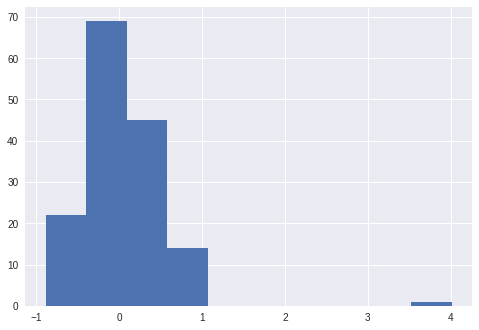

In [17]:
%matplotlib inline
import numpy as np
import seaborn as sns

### Check prots that changed the most
df_val = pd.merge(df_prot1, df_prot2, on='cplx')
df_val.loc[:,'dv'] = df_val.v_y - df_val.v_x
df_val.loc[:,'f_dv'] = df_val.dv / df_val.v_x
df_val.loc[:,'l2fc'] = np.log2(df_val.v_y / df_val.v_x)

sns.plt.hist(df_val.l2fc[ (~df_val.l2fc.isnull()) & (df_val.l2fc < np.inf)])

In [18]:
df_val[ df_val.l2fc.abs() >= 1].shape
cplxs_changed = df_val[ df_val.l2fc.abs() >= 1]['cplx'].unique()
print len(cplxs_changed)

44


In [19]:
dsplot = pd.concat([df_prot1, df_prot2])
dsplot2 = dsplot[ dsplot.cplx.isin(cplxs_changed)]
dsplot2.loc[:,'group'] = 'DelayME'

/usr/lib/python2.7/site-packages/pandas/core/indexing.py:337 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/pandas/core/indexing.py:517 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
dsplot2.head(2)

,cplx,v,type,group
8,NTD11_E_c,0.0,slow,DelayME
57,ASPTA_E_c,0.0,slow,DelayME


In [21]:
dsplot2[ dsplot2.v == dsplot2.v.max()]

,cplx,v,type,group
521,SERD_L_E_c,541.745197,fast,DelayME


In [22]:
dsplot2[ dsplot2.cplx=='SERD_L_E_c']

,cplx,v,type,group
246,SERD_L_E_c,0.000000,slow,DelayME
521,SERD_L_E_c,541.745197,fast,DelayME


In [23]:
dsolver.me.reactions.abundance_SERD_L_E_c.reaction

'mu SERD_L_E_c + enzyme_capacity_SERD_L_E_c --> delayed_abundance_SERD_L_E_c'

In [24]:
print dsolver.me.reactions.dedt_SERD_L_E_c.id, ':', dsolver.me.reactions.dedt_SERD_L_E_c.reaction
print 'v:', dsolver.me.reactions.dedt_SERD_L_E_c.x
print dsolver.me.reactions.ES_SERD_L.id,':', dsolver.me.reactions.ES_SERD_L.reaction
print 'v:', dsolver.me.reactions.ES_SERD_L.x
rxn = dsolver.me.reactions.abundance_SERD_L_E_c
print rxn.id, ':', rxn.reaction
print 'v:', rxn.x

dedt_SERD_L_E_c : SERD_L_E_c + delayed_abundance_SERD_L_E_c <=> 
v: 541.745197236
ES_SERD_L : 0.000333333333333333*mu + 0.004 SERD_L_mRNA_c --> SERD_L_E_c
v: 1000.0
abundance_SERD_L_E_c : mu SERD_L_E_c + enzyme_capacity_SERD_L_E_c --> delayed_abundance_SERD_L_E_c
v: 541.745197236


In [25]:
dsolver.me.metabolites.SERD_L_E_c.reactions

frozenset({<ComplexFormation formation_LSERINEDEAM1-MONOMER_mod_4fe4s at 0x7f02aabcdcd0>,
           <ComplexFormation formation_CPLX0-7622_mod_4fe4s at 0x7f02aabcdfd0>,
           <ComplexFormation formation_LSERINEDEAM2-MONOMER_mod_4fe4s at 0x7f02aabd6410>,
           <ProteinAbundance abundance_SERD_L_E_c at 0x7f02ac27f750>,
           <ProteinDifferential dedt_SERD_L_E_c at 0x7f02ab0799d0>,
           <TranslationReaction ES_SERD_L at 0x7f02ab126c50>})

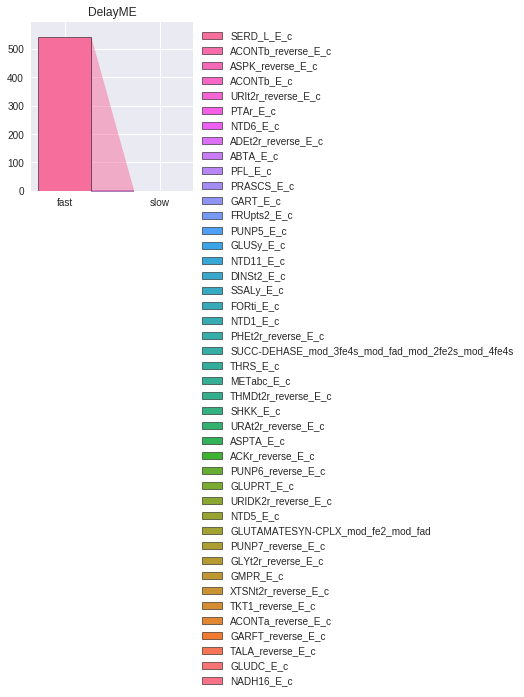

In [26]:
from stressme.plot import stacked_bar

stacked_bar('type', 'v', dsplot2, 'cplx', 'group')

# Test 5: for a shorter time horizon, there may not be a faster proteome in the vicinity of the initial proteome
1. meaning the initial proteome will be kept indefinitely until conditions change, forcing slower growth
1. Also implies that short-term greedy growth maximization strategy won't always work under environmental changes
1. This is why regulation is needed to force short-term growth decrease to build up a better proteome that pays off after an adjustment time (lag, diauxie)

## Preset bioreactor simulation

In [27]:
import warnings

T = 10   # hours
V = 1.   # L
X0 = 0.00675 / V  # g/L
c0_dict = {'glc__D_e': 0.4,
           'lac__L_e': 0.4,
           'malt_e': 0.4,
           'gal_e': 0.4,
           'glyc_e':0.4,
           'ac_e': 0.0}

### Convert from g/L to mmol
mids_remove = []
for mid,c in c0_dict.iteritems():
    try:        
        met = me.metabolites.get_by_id(mid)    
        c0_dict[met.id] = c / met.formula_weight * 1000
    except KeyError:
        warnings.warn('Model has no metabolite: %s. Will remove it from c0_dict' % mid)
        mids_remove.append(mid)

for mid in mids_remove:
    c0_dict.pop(mid)
        
### Set max uptake rate
LB_EX = -10.
LB_O2 = -20.

lb_dict={}
ub_dict={}

for mid in c0_dict.keys():
    try:
        rxn = dyme.get_exchange_rxn(mid)    
        if rxn.id is 'EX_o2_e':
            lb = LB_O2
        else:
            lb = LB_EX
        rxn.lower_bound = lb
        lb_dict[rxn.id] = lb
    except KeyError:
        warnings.warn('Model has no metabolite: '+ mid)

me.reactions.EX_o2_e.lower_bound = -20.
lb_dict[me.reactions.EX_o2_e.id] = -20.
        
print c0_dict
print lb_dict

{'ac_e': 0.0, 'glc__D_e': 2.220299442904667}
{'EX_glc_e': -10.0, 'EX_ac_e': -10.0, 'EX_o2_e': -20.0}


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:20 UserWarning: Model has no metabolite: glyc_e. Will remove it from c0_dict
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:20 UserWarning: Model has no metabolite: malt_e. Will remove it from c0_dict
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:20 UserWarning: Model has no metabolite: lac__L_e. Will remove it from c0_dict
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:20 UserWarning: Model has no metabolite: gal_e. Will remove it from c0_dict


### Seed with suboptimal proteome (slower growth on same substrate)

In [28]:
F_SUBOPT = 0.5

In [29]:
sol_sub = solver.solvelp(mu_me*F_SUBOPT, basis=solver.lp_hs)

In [30]:
cplx_concs = get_cplx_concs(solver)
cplx_conc_dict0 = dict(cplx_concs)

In [31]:
import numpy as np
cvals = np.array(cplx_conc_dict0.values())
cvals[ cvals>0].min()

9.8355992365380607e-09

In [32]:
dyme = DelayedDynamicME(solver)

In [33]:
solver.set_realopts('lp', {'Feasibility tol':1e-15, 'Optimality tol':1e-15})

In [34]:
%%time
### Make sure it solves
dyme.delay_model.update_horizon(0.05)
delay_solver = dyme.delay_model.solver
x,stat,hs = delay_solver.solvelp(mu_me*F_SUBOPT*0.999)
dme = dyme.delay_model.mod_me
MU0 = dme.reactions.biomass_dilution.x
print 'DelayME:', stat, 'at', MU0

DelayME: optimal at 0.422520172119
CPU times: user 4.19 s, sys: 83.3 ms, total: 4.27 s
Wall time: 4.21 s


### One thing's for sure: proteome history is a major constraint on re-allocation rate

In [35]:
if PROTOTYPE:
    fluxes_plot = ['ACONTa_CPLX0-7760_mod_4fe4s', 'ACONTb_CPLX0-7760_mod_4fe4s', 'ACKr_reverse']
else:
    fluxes_plot = ['']

In [36]:
%%time
extra_rxns_tracked = ['EX_o2_e'] + fluxes_plot

T = 20
dt = 0.5
H = dt

result = dyme.simulate_batch(
    T,    
    c0_dict,
    X0,
    prec_bs=1e-3,
    ZERO_CONC=0.,
    extra_rxns_tracked=extra_rxns_tracked,
    lb_dict={},
    verbosity=2,
    dt = dt,
    H = H,
    cplx_conc_dict0=cplx_conc_dict0)

Metabolite ac_e depleted.
Metabolite glc__D_e available.
Using default LB=-1000 for EX_glc_e
Computing new uptake rates
Biomass at t=0.5: 0.0134967
Concentrations: {'ac_e': 0.00042816178016877754, 'glc__D_e': 2.1762205370119423}
Growth rate: 1.9990234375
Metabolite ac_e available.
Using default LB=-1000 for EX_ac_e
Metabolite glc__D_e available.
Using default LB=-1000 for EX_glc_e
Computing new uptake rates
Biomass at t=1: 0.0269868
Concentrations: {'ac_e': 0.0074435494894294603, 'glc__D_e': 2.1226207089582902}
Growth rate: 1.9990234375
Metabolite ac_e available.
Using default LB=-1000 for EX_ac_e
Metabolite glc__D_e available.
Using default LB=-1000 for EX_glc_e
Computing new uptake rates
Biomass at t=1.5: 0.0539605
Concentrations: {'ac_e': 0.03032763074080241, 'glc__D_e': 2.0638751851915096}
Growth rate: 1.9990234375
Metabolite ac_e available.
Using default LB=-1000 for EX_ac_e
Metabolite glc__D_e available.
Using default LB=-1000 for EX_glc_e
Computing new uptake rates
Biomass at t=

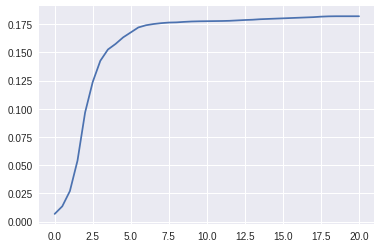

In [37]:
import seaborn as sns
%matplotlib inline

sns.plt.plot(result['time'], result['biomass'])

In [38]:
ex_met_rxn_dict = {m: {'rxn':dyme.get_exchange_rxn(m), 'mw':me.metabolites.get_by_id(m).formula_weight} for m in c0_dict.keys()}
ex_met_rxn_dict

{'ac_e': {'mw': 59.04402,
  'rxn': <MetabolicReaction EX_ac_e at 0x7f02aac05cd0>},
 'glc__D_e': {'mw': 180.15588,
  'rxn': <MetabolicReaction EX_glc_e at 0x7f02abb235d0>}}

In [39]:
import pandas as pd

df_conc = pd.DataFrame(result['concentration'])
### Convert concentrations to g/L
for mid, vals in ex_met_rxn_dict.iteritems():
    df_conc[mid] = df_conc[mid] * vals['mw'] * 0.001

df_time = pd.DataFrame({'time':t, 'biomass':b} for t,b in zip(result['time'], result['biomass']))
df_flux = pd.DataFrame(result['ex_flux'])
df_mu   = pd.DataFrame({'mu':result['growth_rate']})
df_result = pd.concat([df_time, df_conc, df_flux, df_mu], axis=1)
#df_result

In [40]:
dsplot = pd.melt(df_result, id_vars='time', value_vars=['biomass','ac_e','gal_e','glc__D_e','glyc_e','lac__L_e','malt_e'])
dsplot.time = pd.to_numeric(dsplot.time)
dsplot['category'] = 'Metabolite'
dsplot.loc[ dsplot.variable=='biomass', 'category'] = 'Biomass'

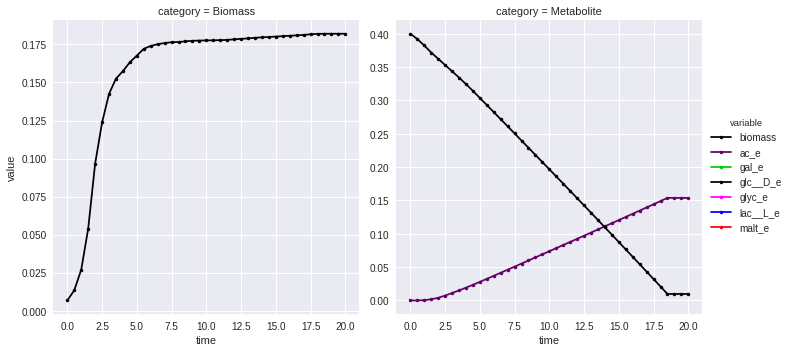

In [41]:
colors = [
'#000000', # biomass
'#660066', # acetate
'#00CC00', #'#00FF00', # galactose
'#000000', # glucose
'#FF00FF', # glycerol
'#0000FF', # lactate
'#FF0000', # maltose
]

colpal = sns.color_palette(colors)
sns.set_palette(colpal)

g = sns.FacetGrid(data=dsplot, hue='variable', col='category', sharey=False, size=5)

g.map(sns.plt.plot, 'time', 'value', linestyle='-', marker='.')
g.add_legend()

In [42]:
if PROTOTYPE:
    complexes_plot = ['IPPMIa_E_c', 'ACKr_reverse_E_c', 'CPLX0-7760_mod_4fe4s','CPLX0-7761_mod_4fe4s']
else:
    complexes_plot = ['3-ISOPROPYLMALISOM-CPLX_mod_4fe4s', 'ACETATEKINA-MONOMER_mod_mg2', 'CPLX0-7659']

In [127]:
df_mu = pd.DataFrame([{'time':t, 'variable':'growth_rate', 'value':c, 'category':'growth'} for t,c in zip(result['time'], result['growth_rate'])] )

df_complex = pd.DataFrame([{'time':t, 'complex':c, 'abundance':cdict[c]} 
                           for t,cdict in zip(result['time'], result['complex']) for c in complexes_plot] )

df_mflux = pd.DataFrame([{'time':t, 'rxn':c, 'flux':cdict[c]} 
                           for t,cdict in zip(result['time'], result['rxn_flux']) for c in fluxes_plot] )

df_complex.loc[:,'category'] = 'complex'
df_mflux.loc[:,'category'] = 'flux'

dsplot_all = pd.concat([dsplot,
                        df_mu,
                          df_complex.rename(columns={'complex':'variable', 'abundance':'value'}),
                          df_mflux.rename(columns={'rxn':'variable', 'flux':'value'})])

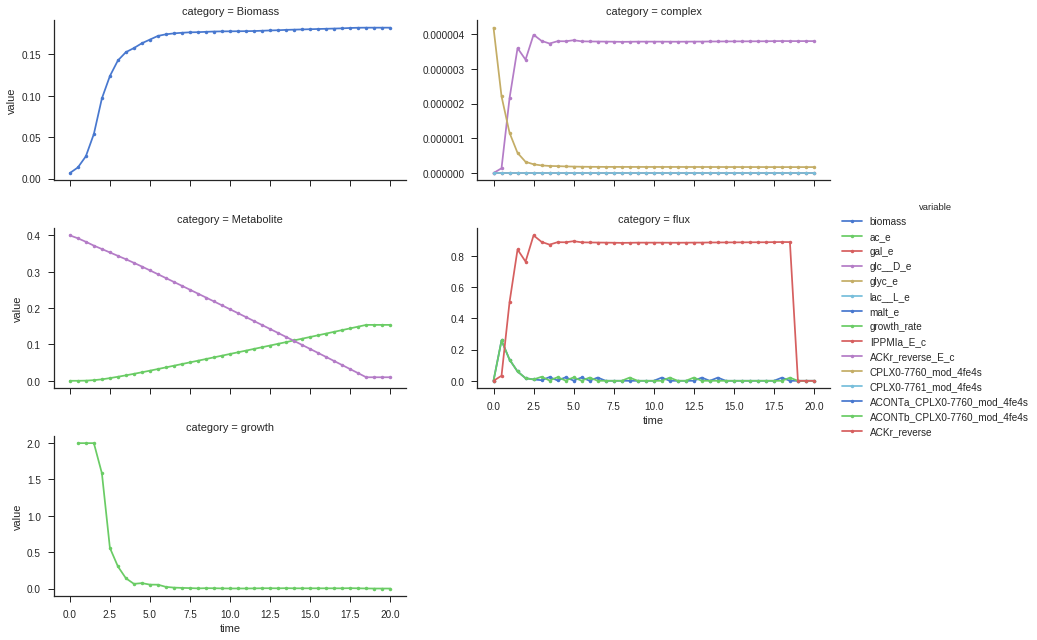

In [129]:
sns.set_style('ticks')
palette = sns.color_palette('muted', len(dsplot_all.variable.unique()))
g = sns.FacetGrid(data=dsplot_all, hue='variable', sharey=False, size=3, col='category', palette=palette,
                  aspect=2, col_wrap=2, col_order=['Biomass','complex','Metabolite','flux','growth'])
g.map(sns.plt.plot, 'time', 'value', linestyle='-', marker='.')
g.add_legend()

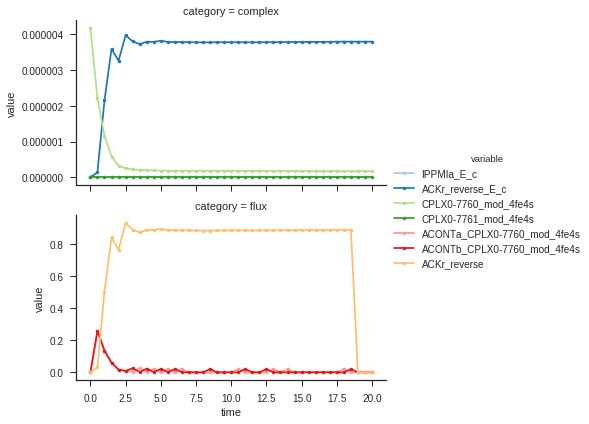

In [63]:
sns.set_style('ticks')
dfi = dsplot_all[ dsplot_all.category.isin(['complex','flux'])]
palette = sns.color_palette('Paired', len(dfi.variable.unique()))
g = sns.FacetGrid(data=dfi, hue='variable', sharey=False, size=3, row='category', palette=palette, aspect=2)
g.map(sns.plt.plot, 'time', 'value', linestyle='-', marker='.')
g.add_legend()

## Proteome mole (mass) fractions

In [80]:
df_cplx = pd.DataFrame([{'cplx':k, 'conc':v, 'time':result['time'][i]} for i,r in enumerate(result['complex']) for k,v in r.iteritems()])

In [89]:
times = df_cplx.time.unique()
for t in times:
    dfi = df_cplx[ df_cplx.time==t]
    mtot = dfi.conc.sum()
    b = (df_cplx.time==t).values
    df_cplx.loc[b,'molf'] = df_cplx.loc[b,'conc'] / mtot

In [91]:
df_cplx.head(2)

,conc,cplx,time,molf
0,0.0,GLYBt2r_E_c,0.0,0.0
1,0.0,DHQD_reverse_E_c,0.0,0.0


In [106]:
df_var = df_cplx.groupby('cplx').molf.var().reset_index()
df_var.molf.min()
df_var.molf.max()
N_PLOT = 10
vary_cplxs = df_var.sort_values('molf', ascending=False)['cplx'][0:N_PLOT].values
vary_cplxs

array(['CYTK2_E_c', 'CYTK2_reverse_E_c', 'PFL_E_c', 'FORti_E_c',
       'PTAr_E_c', 'ACKr_reverse_E_c', 'ADHE-CPLX_mod_fe2', 'PYK_E_c',
       'PGM_reverse_E_c', 'ENO_E_c'], dtype=object)

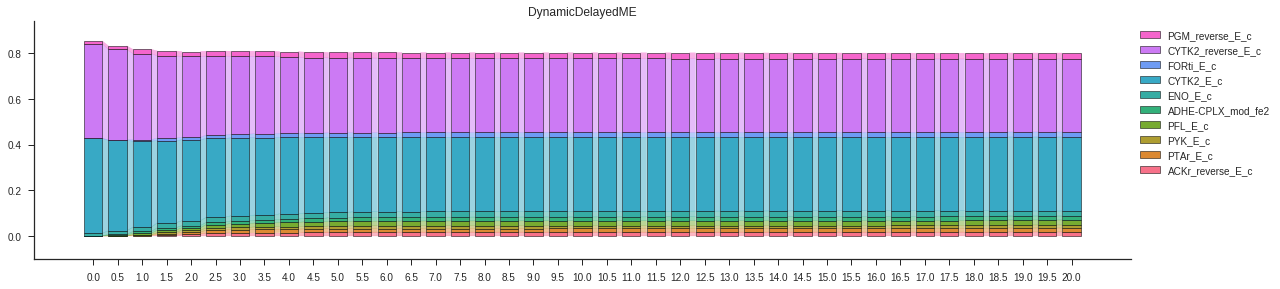

In [116]:
dsplot_cplx = df_cplx[ df_cplx.cplx.isin(vary_cplxs)]
dsplot_cplx.loc[:,'group'] = 'DynamicDelayedME'
stacked_bar('time', 'molf', dsplot_cplx, 'cplx', 'group', aspect=4, size=4, width=0.75)

## Expression fluxes

## Check |slacks|>ftol for equality constraints to find infeasible

- Ax + s = 0
- Ax = -s

import numpy as np
infeas_cons = {}

ZERO = 1e-15
N = len(dsolver.me.reactions)
M = len(dsolver.me.metabolites)
           
for met in dsolver.me.metabolites:
    if met._constraint_sense == 'E':
        i = dsolver.me.metabolites.index(met)        
        s = x[N+i]
        b = met._bound
        e = b+s # since -s = b OR b+s = 0
        if abs(e) > ZERO:
            infeas_cons[met.id] = e
max_abs_infeas = max(abs(np.array(infeas_cons.values())))
print 'Max abs primal infeas:', max_infeas
print 'Min abs primal infeas:', min(abs(np.array(infeas_cons.values())))
print 'Sum of abs infeas:', sum(abs(np.array(infeas_cons.values())))
print '# of infeasibilities:', len(infeas_cons)